In [1]:
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:


class AbstractDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        abstract = self.df.iloc[idx]["abstract_lg"]
        topic = self.df.iloc[idx]["topic_int"]
        encoding = self.tokenizer.encode_plus(
            abstract,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(topic, dtype=torch.long),
        }

test_df = pd.read_csv("test_bert.csv")

# Load the best model after training
model = BertForSequenceClassification.from_pretrained("bert_model")

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create the test dataset
test_dataset = AbstractDataset(
    df=test_df,
    tokenizer=tokenizer,
    max_length=512,
)

# Create the Trainer object
training_args = TrainingArguments(
    output_dir='./results',  # output directory
    per_device_eval_batch_size=8,  # batch size for evaluation
)
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
)

# Evaluate the model on the test dataset
eval_results = trainer.evaluate()

# In[ ]:

def get_predictions(model, tokenizer, dataset):
    predictions = []
    for item in dataset:
        input_ids = item["input_ids"].unsqueeze(0).to(model.device)
        attention_mask = item["attention_mask"].unsqueeze(0).to(model.device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_label = logits.argmax(dim=1).item()
        predictions.append(predicted_label)
    return predictions


y_true = test_df["topic_int"].tolist()
y_pred = get_predictions(model, tokenizer, test_dataset)

print(classification_report(y_true, y_pred))



              precision    recall  f1-score   support

           0       0.97      0.99      0.98       686
           1       0.98      0.98      0.98       204
           2       0.98      0.97      0.97       250
           3       0.99      0.98      0.99       374
           4       0.97      0.99      0.98       876
           5       0.99      0.98      0.98      1133
           6       0.98      0.97      0.98       755

    accuracy                           0.98      4278
   macro avg       0.98      0.98      0.98      4278
weighted avg       0.98      0.98      0.98      4278



BERT Confusion Matrix:


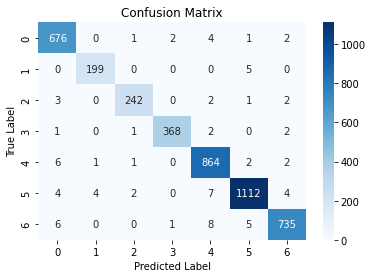

In [3]:
cm_bert = confusion_matrix(y_true, y_pred)
print("BERT Confusion Matrix:")

# visualize the confusion matrix
sns.heatmap(cm_bert, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
test_df['bert_preds'] = y_pred

In [ ]:
test_df.to_csv("LitCovid_bert.csv")